# Distributed ML using PySpark


### Notebook Set-Up



In [2]:
!pip install seaborn

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [312]:
# imports
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [337]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "hello_world"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [338]:
# sc.stop()

You can monitor the progress of your jobs using the Spark UI at: http://localhost:4040/jobs/

In [339]:
corpus = [
    "Peter Piper picked a peck of pickled peppers",
    "a peck of pickled peppers Peter Piper picked",
    "if Peter Piper picked a peck of pickled peppers",
    "where’s the peck of pickled peppers that Peter Piper picked",
    "peck picker"
]
rdd = sc.parallelize(corpus)
rdd.top(2)
sys.getsizeof(rdd)

56

In [333]:
def emit_words(document):
    for word in document.split():
        yield (word, 1)

word_emissions_rdd = rdd.flatMap(emit_words)
sys.getsizeof(word_emissions_rdd.collect())

376

In [334]:
word_counts_rdd = word_emissions_rdd.reduceByKey(lambda aggregated, current: aggregated + current)
word_counts_rdd.collect()

[('of', 4),
 ('a', 3),
 ('where’s', 1),
 ('that', 1),
 ('picker', 1),
 ('pickled', 4),
 ('peck', 5),
 ('the', 1),
 ('picked', 4),
 ('peppers', 4),
 ('Peter', 4),
 ('Piper', 4),
 ('if', 1)]

In [340]:
rdd.flatMap(emit_words).reduceByKey(lambda x, y: x + y).sortBy(lambda x: -x[1]).collect()[0]
rdd.flatMap(emit_words).reduceByKey(lambda x, y: x + y).takeOrdered(1, key=lambda x: -x[1])

[('peck', 5)]

In [243]:
rdd.flatMap(emit_words).reduceByKey(lambda x, y: x + y).sortBy(lambda x: -x[1]).collect()[0]
sorted(rdd.flatMap(emit_words).countByKey().items(), key = lambda x: x[1], reverse=True)[0]

('peck', 5)

# About the Data

For the main task we will use data about red and white Portuguese wines. [This data](http://archive.ics.uci.edu/ml/datasets/Wine+Quality) was made available to the UC Irvine public repository of Machine Learning datasets by researchers at the University of Minho in association with [this paper](https://www.sciencedirect.com/science/article/pii/S0167923609001377?via%3Dihub):
> P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

The dataset includes 12 fields:
>`fixed acidity`  
`volatile acidity`  
`citric acid`  
`residual sugar`  
`chlorides`  
`free sulfur dioxide`  
`total sulfur dioxide`  
`density`  
`pH`  
`sulphates`  
`alcohol`  
`quality`   -- (_a score between 0 and 10_)

__`IMPORTANT NOTE:`__ The outcome variable in our data is a human assigned score ranging from 0 to 10. Since the scores are integers this is actually an ordinal and not numerical outcome varaible. However for the purposes of this assignment we'll treat it as a numerical quantity.

The data are in two files: one containing red wines and another containing white wines.

In [9]:
# make a data folder & download red & white wine files
# !mkdir data
!wget -q -O data/reds.csv http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
!wget -q -O data/whites.csv http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv

In [341]:
# Getting the headers
data_file = 'data/whites.csv'
header = !head -n 1 $data_file
FIELDS = re.sub('"', '', header[0]).split(';')
TARGET_FIELD = FIELDS[-1]
FIELDS

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

In [342]:
# load the raw data into an RDD - RUN THIS CELL AS IS
rdd = sc.textFile(data_file).filter(lambda x: x != header[0])
rdd.collect()[:5]

['7;0.27;0.36;20.7;0.045;45;170;1.001;3;0.45;8.8;6',
 '6.3;0.3;0.34;1.6;0.049;14;132;0.994;3.3;0.49;9.5;6',
 '8.1;0.28;0.4;6.9;0.05;30;97;0.9951;3.26;0.44;10.1;6',
 '7.2;0.23;0.32;8.5;0.058;47;186;0.9956;3.19;0.4;9.9;6',
 '7.2;0.23;0.32;8.5;0.058;47;186;0.9956;3.19;0.4;9.9;6']

In [343]:
def parse_line(line):
    delimiter = ';'
    fields = np.array(line.split(delimiter), dtype = 'float')
    features, target_variable = fields[:-1], fields[-1]
    return(features, target_variable)

In [344]:
rdd = rdd.map(parse_line).cache()

In [346]:
rdd.collect()[:5]

[(array([7.000e+00, 2.700e-01, 3.600e-01, 2.070e+01, 4.500e-02, 4.500e+01,
         1.700e+02, 1.001e+00, 3.000e+00, 4.500e-01, 8.800e+00]), 6.0),
 (array([6.30e+00, 3.00e-01, 3.40e-01, 1.60e+00, 4.90e-02, 1.40e+01,
         1.32e+02, 9.94e-01, 3.30e+00, 4.90e-01, 9.50e+00]), 6.0),
 (array([8.100e+00, 2.800e-01, 4.000e-01, 6.900e+00, 5.000e-02, 3.000e+01,
         9.700e+01, 9.951e-01, 3.260e+00, 4.400e-01, 1.010e+01]), 6.0),
 (array([7.200e+00, 2.300e-01, 3.200e-01, 8.500e+00, 5.800e-02, 4.700e+01,
         1.860e+02, 9.956e-01, 3.190e+00, 4.000e-01, 9.900e+00]), 6.0),
 (array([7.200e+00, 2.300e-01, 3.200e-01, 8.500e+00, 5.800e-02, 4.700e+01,
         1.860e+02, 9.956e-01, 3.190e+00, 4.000e-01, 9.900e+00]), 6.0)]

In [348]:
# Train test split
TRAIN_TEST_SPLIT = 0.8
train_rdd, validate_rdd = rdd.randomSplit([TRAIN_TEST_SPLIT, 1 - TRAIN_TEST_SPLIT], seed = 1)
print(f"Number of training records: {train_rdd.count()}\nNumber of validation records: {validate_rdd.count()}")

Number of training records: 3917
Number of validation records: 981


# EDA

A statistician's approach to Linear Regression typically involves a series of EDA steps to examine each feature in the data and then series of steps to test assumptions about their potential contribution to a multi-feature linear model. In particular, we'd want to look for a set of features that exhibit a likely linear relationship with the outcome variable and that are _not_ highy correlated with each other. In the context of machine learning, these considerations remain important techniques for improving model generalizability despite the common practice to use model evaluation techniques (and large data sets) to get the final word on feature selection. 

Next, we'll briefly look at the features in our data set. To mimic an 'at scale' analysis we'll start by sampling from our Spark RDD training set so that we have a manageable amount of data to work with in our visuals.


In [349]:
# take a 1000 point sample for EDA
sample = np.array(train_rdd.map(lambda x: np.append(x[0], [x[1]]))
                                .takeSample(False, 1000))
sample_df = pd.DataFrame(np.array(sample), columns = FIELDS)

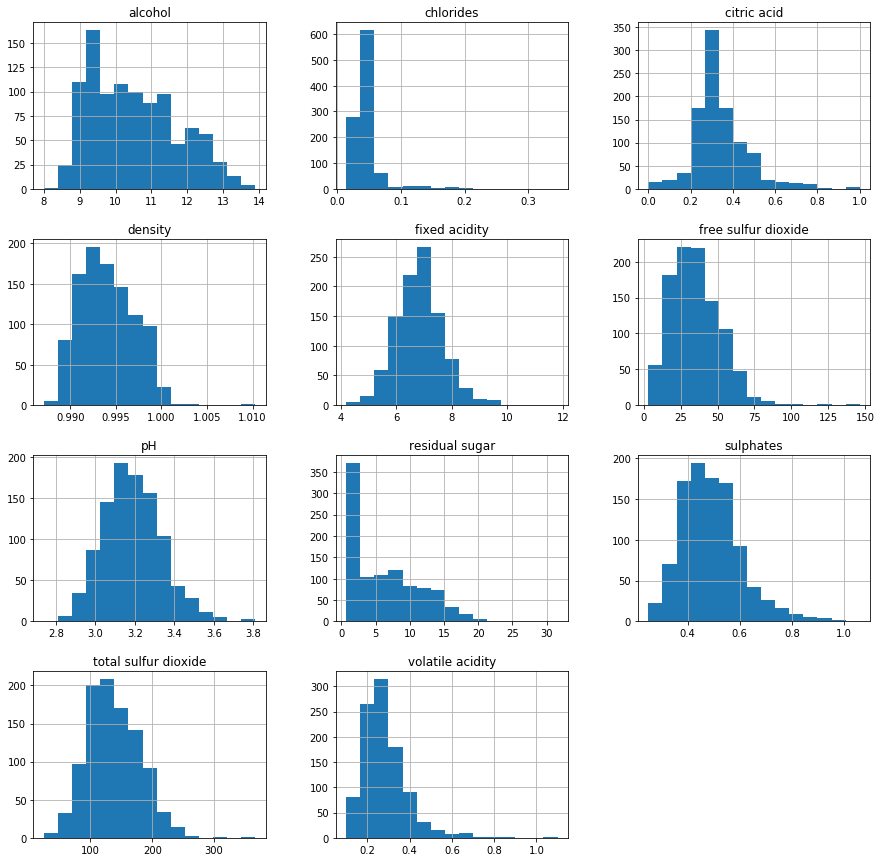

In [350]:
# take a look at histograms for each feature
sample_df[FIELDS[:-1]].hist(figsize=(15,15), bins=15)
plt.show()

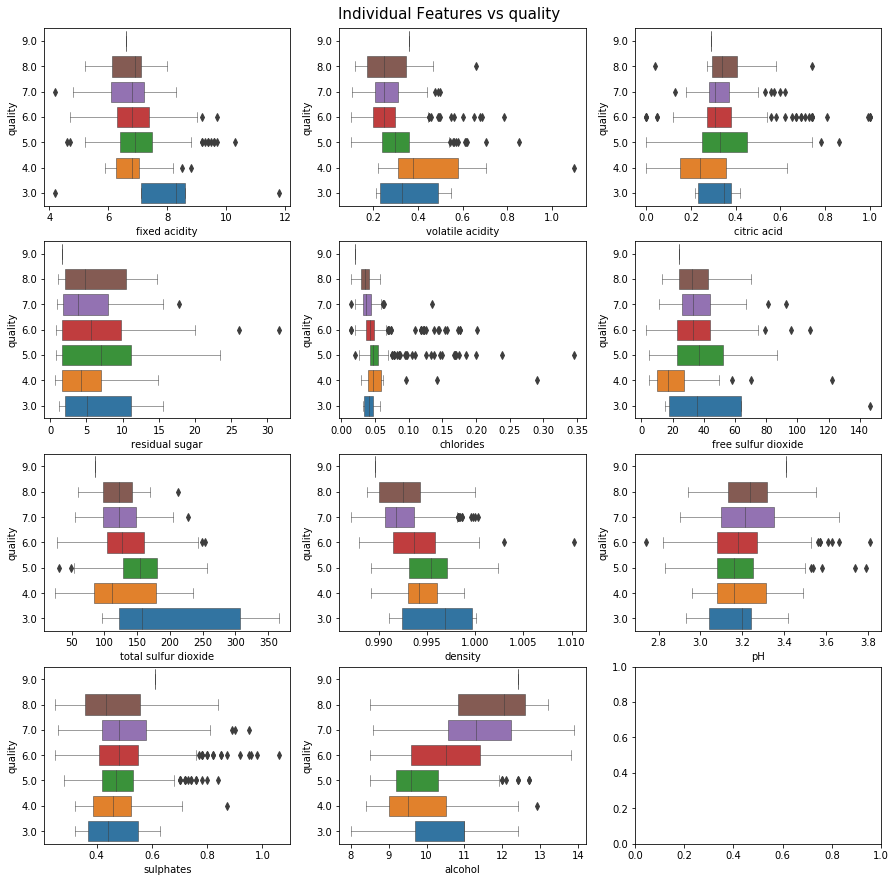

In [351]:
# plot boxplots of each feature vs. the outcome
fig, ax_grid = plt.subplots(4, 3, figsize=(15,15))
y = sample_df[TARGET_FIELD]
for idx, feature in enumerate(FIELDS[:-1]):
    x = sample_df[feature]
    sns.boxplot(x, y, ax=ax_grid[idx//3][idx%3], orient='h', linewidth=.5)
    ax_grid[idx//3][idx%3].invert_yaxis()
fig.suptitle(f"Individual Features vs {TARGET_FIELD}", fontsize=15, y=0.9)
plt.show()

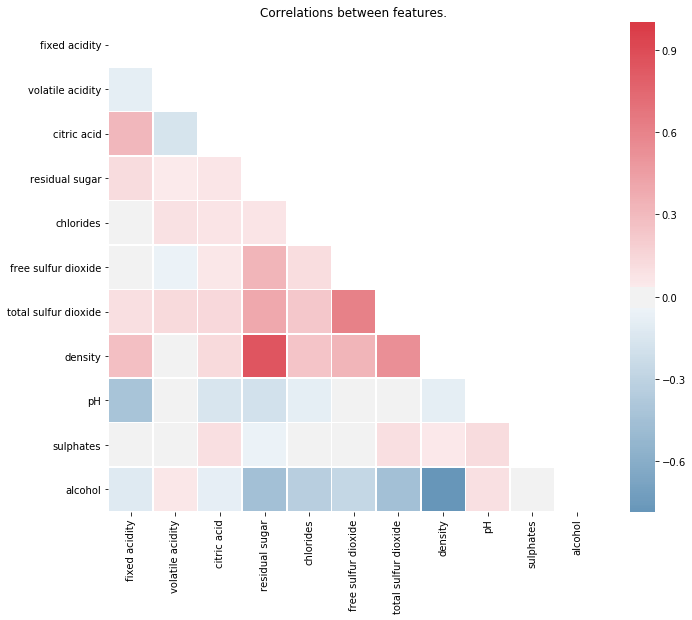

In [76]:
# plot heatmap for correlations matrix - RUN THIS CELL AS IS
corr = sample_df[FIELDS[:-1]].corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between features.")
plt.show()

## Some observations
- pH seems to be normally distributed, the feature varying the most is 'alcohol'. Color is different because it is a categorical variable instead of a contiuous one unlike others.
-  Color, chlorides, volatile acidity are positively correlated amongst eachother. The total SO2 is correlated to free S02 (which is quite obvious), and in the same way density is negatively correlated to alcohol content, and color is also negatively correlated to SO2 content.

# OLS Loss

For a parametric model, the key factor that will impact how easy it is to optimize is your choice of how to define the loss function. In Ordinary Least Squares (OLS) Regression our loss function is just about as convenient as you will get: not only is it convex, its also very easy to interpret. Next, we'll "choose" a baseline model and then write a function to compute the loss of a linear model in Spark. We'll reuse this function when we implement gradient descent.


In [353]:
mean_target_value = train_rdd.map(lambda x: x[1]).mean()
target_variance = train_rdd.map(lambda x: x[1]).variance()
print(f"Mean: {mean_target_value}")
print(f"Variance: {target_variance}")

Mean: 5.8726065866734745
Variance: 0.7800435758871745


In [354]:
def squared_error(args):
    label, prediction = args[0], args[1]
    return (label - prediction)*(label - prediction)

def ols_loss(rdd, weights):
    # Augmenting data for bias
    augmented_data = rdd.map(lambda x: (np.append([1.0], x[0]), x[1]))
    loss = augmented_data.map(lambda x: (np.dot(x[0], weights), x[1])).map(squared_error).mean()
    return np.sqrt(loss)

In [357]:
# Baseline model
BASELINE = np.append([mean_target_value], np.zeros(len(train_rdd.take(1)[0][0]), dtype=np.float64))
print(BASELINE)
print(f"Baseline model loss: {ols_loss(train_rdd, BASELINE)}")

[5.87260659 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
Baseline model loss: 0.8832007562763831


# Vanilla Gradient Descent

Performing Gradient Descent technically only requires two steps: 1) _use the current model to calculate the gradient_; 2) _use the gradient to update the current model parameters_. In practice though, we'll want to add a third step which is to compute the loss for our new model so that we can see if its working. Next, we'll implement gradient descent for OLS regression and take a look at a few update steps.

In [89]:
def gradient_summand(weights, lp):
     return (weights.dot(lp.features) - lp.label) * lp.features

    
def gradient_descent_update(rdd, weights, lr=0.1):
    """
    Performs one gradient descent update. Returns updated coefficients,
    with bias at index 0.
    """
    # Add a feature of 1 corresponding to bias at index 0
    augmented_data = rdd.map(lambda x: (np.append([1.0], x[0].astype(np.float32, copy=False)), x[1])).cache()

    gradients = augmented_data.map(lambda x: (np.dot(x[0], weights), x[1], x[0])).map(lambda x: np.dot(x[0]- x[1], x[2]))
    total = gradients.count()
    sum_of_gradients = gradients.sum()
    
    # Update weights
    updated_weights = weights - lr * (1.0 / total) * sum_of_gradients
   
    return updated_weights

In [99]:
def normalize(rdd):
    feature_means = rdd.map(lambda x: x[0]).mean()
    features_standard_dev = np.sqrt(rdd.map(lambda x: x[0]).variance())
    normed_rdd = rdd.map(lambda x: (np.subtract(x[0], feature_means) / features_standard_dev, x[1]))
    return normed_rdd

In [100]:
normalized_rdd = normalize(train_rdd_parsed).cache()

In [102]:
num_iterations = 15
model = BASELINE.astype(np.float32, copy=False)
print(f"BASELINE:  Loss = {ols_loss(normalized_rdd, model)}")
for idx in range(num_iterations):
    print("----------")
    print(f"STEP: {idx+1}")
    model = gradient_descent_update(normalized_rdd, model)
    loss = ols_loss(train_rdd_parsed, model)
    print(f"Loss: {loss}")
    print(f"Model: {[round(w,3) for w in model]}")

BASELINE:  Loss = 0.8832007562763986
----------
STEP: 1
Loss: 2.028071184287234
Model: [5.873, -0.009, -0.018, -0.001, -0.008, -0.019, 0.001, -0.015, -0.026, 0.008, 0.005, 0.038]
----------
STEP: 2
Loss: 2.964681097115866
Model: [5.873, -0.016, -0.033, -0.0, -0.01, -0.033, 0.005, -0.025, -0.045, 0.014, 0.009, 0.068]
----------
STEP: 3
Loss: 3.3865135752330184
Model: [5.873, -0.021, -0.047, 0.001, -0.009, -0.044, 0.01, -0.03, -0.058, 0.019, 0.013, 0.093]
----------
STEP: 4
Loss: 3.468636638008892
Model: [5.873, -0.024, -0.059, 0.003, -0.005, -0.053, 0.016, -0.034, -0.067, 0.022, 0.017, 0.114]
----------
STEP: 5
Loss: 3.3436880471463932
Model: [5.873, -0.027, -0.07, 0.005, 0.001, -0.06, 0.023, -0.036, -0.074, 0.024, 0.021, 0.132]
----------
STEP: 6
Loss: 3.101960874772143
Model: [5.873, -0.029, -0.08, 0.007, 0.007, -0.065, 0.029, -0.037, -0.079, 0.026, 0.024, 0.148]
----------
STEP: 7
Loss: 2.8037367680436627
Model: [5.873, -0.031, -0.089, 0.009, 0.015, -0.069, 0.035, -0.038, -0.083, 0.0

# Assessing the performance of our model.

Printing out the loss as we perform each gradient descent step allows us to confirm that our Gradient Descent code appears to be working, but this number doesn't accurately reflect "how good" our model is. Next, we'll plot error curves for a test and training set in order to discuss model performance. Note that although we split out a test & train set when we first loaded the data... in the spirit of keeping that 20% truly 'held out' until then end of the assignment, we'll make an additional split dividing the existing training set into two smaller RDDs.


In [116]:

def gradient_descent(train_rdd, test_rdd, initial_weights, num_iterations=20, 
                    lr = 0.1):   
    # tracking the history
    train_losses, test_losses, model_parameters = [], [], []

    model = initial_weights
    for idx in range(num_iterations): 
        
        model = gradient_descent_update(rdd=train_rdd, weights=model)
        training_loss = ols_loss(train_rdd, model)
        test_loss = ols_loss(test_rdd, model)
        
        train_losses.append(training_loss)
        test_losses.append(test_loss)
        model_parameters.append(model)
        
        print("----------")
        print(f"STEP: {idx+1}")
        print(f"training loss: {training_loss}")
        print(f"test loss: {test_loss}")
        print(f"Model: {[round(w,3) for w in model]}")
        
    return train_losses, test_losses, model_parameters

In [296]:
# plot error curves
def plot_error_curve(train_losses, test_losses, title = None):
    fig, ax = plt.subplots(1, 1, figsize = (16,8))
    x = list(range(len(train_losses)))[1:]
    ax.plot(x, train_losses[1:], 'k--', label='Training Loss')
    ax.plot(x, test_losses[1:], 'r--', label='Test Loss')
    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Mean Squared Error')
    if title:
        plt.title(title)
    plt.show()

In [283]:
# run 50 iterations
initial_weights = BASELINE
train_rdd, test_rdd = normalized_rdd.randomSplit([0.8,0.2], seed = 4)
start = time.time()
train_losses, test_losses, model_parameters = gradient_descent(train_rdd, test_rdd, initial_weights, num_iterations = 50)
print(f"\n... trained {len(train_losses)} iterations in {time.time() - start} seconds")

----------
STEP: 1
training loss: 0.8507676773084367
test loss: 0.8538169166098181
Model: [5.872, -0.008, -0.017, -0.001, -0.007, -0.018, 0.0, -0.014, -0.025, 0.007, 0.005, 0.037]
----------
STEP: 2
training loss: 0.8318974300546926
test loss: 0.8292322779744711
Model: [5.871, -0.013, -0.033, -0.002, -0.009, -0.031, 0.003, -0.023, -0.043, 0.013, 0.01, 0.066]
----------
STEP: 3
training loss: 0.819208759284979
test loss: 0.8122093856939462
Model: [5.87, -0.017, -0.047, -0.001, -0.008, -0.041, 0.008, -0.029, -0.055, 0.016, 0.015, 0.09]
----------
STEP: 4
training loss: 0.8100141096568871
test loss: 0.7996985000360223
Model: [5.87, -0.02, -0.059, -0.0, -0.003, -0.049, 0.013, -0.032, -0.064, 0.019, 0.019, 0.111]
----------
STEP: 5
training loss: 0.8029329835853725
test loss: 0.7900495280059088
Model: [5.869, -0.022, -0.07, 0.001, 0.002, -0.056, 0.018, -0.034, -0.071, 0.021, 0.023, 0.128]
----------
STEP: 6
training loss: 0.7972339206083516
test loss: 0.7823368981288472
Model: [5.869, -0.02

----------
STEP: 47
training loss: 0.7576481391294199
test loss: 0.734966416131157
Model: [5.863, -0.012, -0.191, -0.003, 0.178, -0.038, 0.072, -0.022, -0.113, 0.034, 0.06, 0.35]
----------
STEP: 48
training loss: 0.7575610896326329
test loss: 0.7349301986208071
Model: [5.863, -0.012, -0.191, -0.003, 0.18, -0.037, 0.072, -0.021, -0.114, 0.034, 0.06, 0.352]
----------
STEP: 49
training loss: 0.7574799099214928
test loss: 0.7348995183547609
Model: [5.863, -0.012, -0.192, -0.003, 0.182, -0.036, 0.072, -0.021, -0.114, 0.035, 0.06, 0.353]
----------
STEP: 50
training loss: 0.7574041304497576
test loss: 0.7348738190185478
Model: [5.863, -0.011, -0.193, -0.004, 0.183, -0.036, 0.072, -0.021, -0.115, 0.035, 0.06, 0.354]

... trained 50 iterations in 12.398797035217285 seconds


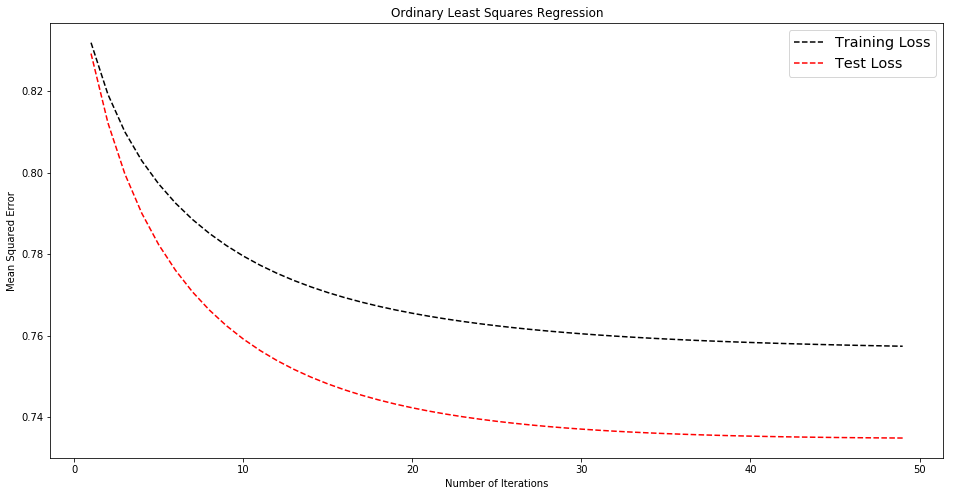

In [284]:
# take a look
plot_error_curve(train_losses, test_losses, title = 'Ordinary Least Squares Regression' )

In [360]:
# save the models & their performance for comparison later
np.savetxt(PWD + '/data/OLSmodels.csv', np.array(models), delimiter=',')
np.savetxt(PWD + '/data/OLSloss.csv', np.array([MSEtrain, MSEtest]), delimiter=',')

# Cross Validation

Computing the loss after each iteration is not strictly a part of Gradient Descent, its just convenient for visualizing our progress. This "third step" however comes with a tradeoff: it requires an extra pass through the data. Normally this would cause us to cringe except for the fact that both the loss computation and the gradient computation are very easy to parallelize - lots of the work can be done in place no shuffle needed for the aggregation. 

Cross validation, which will solve the problem of the unreliable test-loss that we saw previously, presents a bit more of a scalability challenge. To avoid over-dependence on a particulary good or bad test/train split we divide the data into `k` roughly equal size parts and train `k` models. The `k-th` model is trained on all the data _except_ the `k-th` split which is used as a test set for that model. Finally we compute the loss by averaging together the test/train loss for each model. Next, we'll perform gradient descent and cross validation in parallel.

A naive approach to training an OLS Regression model with cross validation might be to simply perform Gradient Descent on each of the 5 models in sequence. But we'll try something better.


In [285]:
def k_residuals(record, models, split_num):
    """
    Compute the MSEs for a data point given k different models. We emit
    a key to be able track the residuals for a model number and train/test type.
    """
    # augment the data point with a bias term at index 0
    X = np.append([1.0], record[0])
    y = record[1]
    for model_num, weights in enumerate(models):
        if model_num == split_num:
            yield(f"{model_num}-test", (weights.dot(X) - y) ** 2)
        else:
            yield(f"{model_num}-train", (weights.dot(X) - y) ** 2)

In [286]:

from collections import Counter

def CV_loss(data_splits, models):
    """
    Compute the k-fold cross-validated test and train loss.
    """
    # compute k residuals for each data point (one for each model)
    partial_loss_rdd = sc.parallelize([])
    for split_num, rdd in enumerate(data_splits):
        residuals = rdd.flatMap(lambda x: k_residuals(x, models, split_num))
        partial_loss_rdd = sc.union([partial_loss_rdd, residuals])
    
    loss = partial_loss_rdd.map(lambda x: (x[0], [x[1]])).reduceByKey(lambda x, y: x + y).map(lambda x: (x[0], np.mean(x[1]))).collect()    
    
    test_loss = np.mean([x[1] for x in loss if x[0].split('-')[1] == 'test'])
    training_loss = np.mean([x[1] for x in loss if x[0].split('-')[1] == 'train'])
    return training_loss, test_loss

In [287]:

def partial_gradient(split_num, data_point, models):
    """
    Emit partial gradient for this data point for each model.
    """
    # augment the data point
    X = np.append([1.0], data_point[0])
    y = data_point[1]
    # emit partial gradients for each model with a counter for averaging later
    for model_num, weights in enumerate(models):
        if model_num != split_num:
            yield (model_num, [(weights.dot(X) - y)*X, 1])

In [288]:

def CV_update(data_splits, models, lr = 0.1):
    """
    Compute gradients for k models given k corresponding dataSplits.
    NOTE: the training set for model-k is all records EXCEPT those in the k-th split.
    """
    # compute partial gradient k-1 times for each fold
    partials_rdd = sc.parallelize([])
    for split_num, rdd in enumerate(data_splits):
        one_fold_partial_grads =  rdd.flatMap(lambda x: partial_gradient(split_num, x, models))
        partials_rdd = sc.union([partials_rdd, one_fold_partial_grads])

    # compute gradients by taking the average partialGrad for each fold
    gradients = partials_rdd.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))\
                           .mapValues(lambda x: x[0]/x[1])\
                           .map(lambda x: x[1])\
                           .collect()
    
    # update all k models & return them in a list
    new_models = []
    for weights, grad in zip(models, gradients):
        new_model = weights - lr * grad
        new_models.append(new_model)
    return new_models

In [289]:

def gradient_descent_with_cv(data_splits, initial_weights, lr=0.1, num_iterations = 5):
    """
    Train k models in parallel and track cross validated test/train loss.
    """
    # broadcast initial models (one for each fold)
    broadcasted_models = sc.broadcast([initial_weights] * len(data_splits))
    
    # initialize lists to track performance
    train_loss_0, test_loss_0 = CV_loss(data_splits, broadcasted_models.value)
    train_losses, test_losses, model_params = [train_loss_0], [test_loss_0], [initial_weights]
    
    # perform k gradient updates at a time (one for each fold)
    start = time.time()
    for step in range(num_iterations):
        new_models = CV_update(data_splits, broadcasted_models.value, lr)
        broadcasted_models = sc.broadcast(new_models)

        # log progress
        train_loss, test_loss = CV_loss(data_splits, broadcasted_models.value)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        model_params.append(new_models[0])
        
        print("-------------------")
        print(f"STEP {step}: ")
        print(f"model 1: {[round(w,4) for w in new_models[0]]}")
        print(f" train loss: {round(train_loss,4)}")
        print(f" test loss: {round(test_loss,4)}")
            
    return train_losses, test_losses, model_params

In [299]:
# run 50 iterations
data_splits = normalized_rdd.randomSplit([1.0 / 6]*6, seed = 2018) 
initial_weights = BASELINE
start = time.time()
train_losses, test_losses, model_parameters = gradient_descent_with_cv(data_splits, initial_weights, num_iterations=50)
print(f"\n... trained {len(train_losses)} iterations in {time.time() - start} seconds")

-------------------
STEP 0: 
model 1: [5.872, -0.0086, -0.0176, -0.0004, -0.0079, -0.0179, 0.0021, -0.0145, -0.0259, 0.0077, 0.0043, 0.0378]
 train loss: 0.7225
 test loss: 0.7234
-------------------
STEP 1: 
model 1: [5.8714, -0.0148, -0.0332, 0.0004, -0.01, -0.0317, 0.0068, -0.0238, -0.0442, 0.0134, 0.0084, 0.0682]
 train loss: 0.688
 test loss: 0.6893
-------------------
STEP 2: 
model 1: [5.8708, -0.0192, -0.047, 0.0019, -0.0084, -0.0426, 0.0128, -0.0296, -0.0572, 0.0175, 0.0122, 0.0933]
 train loss: 0.6655
 test loss: 0.6671
-------------------
STEP 3: 
model 1: [5.8703, -0.0224, -0.0594, 0.0036, -0.0044, -0.0511, 0.0195, -0.0332, -0.0665, 0.0205, 0.0156, 0.1145]
 train loss: 0.6496
 test loss: 0.6514
-------------------
STEP 4: 
model 1: [5.8698, -0.0247, -0.0704, 0.0054, 0.0012, -0.0579, 0.0263, -0.0353, -0.0733, 0.0228, 0.0187, 0.1328]
 train loss: 0.6375
 test loss: 0.6395
-------------------
STEP 5: 
model 1: [5.8694, -0.0264, -0.0802, 0.0072, 0.0076, -0.0632, 0.033, -0.0365,

-------------------
STEP 46: 
model 1: [5.8663, -0.0205, -0.1834, 0.0065, 0.1733, -0.0412, 0.0974, -0.0373, -0.1132, 0.0397, 0.0461, 0.3563]
 train loss: 0.5666
 test loss: 0.5702
-------------------
STEP 47: 
model 1: [5.8663, -0.0201, -0.1839, 0.0063, 0.1749, -0.0403, 0.0974, -0.0372, -0.1137, 0.0399, 0.0462, 0.3576]
 train loss: 0.5665
 test loss: 0.5701
-------------------
STEP 48: 
model 1: [5.8664, -0.0198, -0.1844, 0.006, 0.1764, -0.0394, 0.0973, -0.0371, -0.1143, 0.0402, 0.0462, 0.3589]
 train loss: 0.5664
 test loss: 0.57
-------------------
STEP 49: 
model 1: [5.8664, -0.0194, -0.1849, 0.0057, 0.1779, -0.0385, 0.0973, -0.037, -0.1149, 0.0405, 0.0463, 0.3601]
 train loss: 0.5663
 test loss: 0.5699

... trained 50 iterations in 41.34121775627136 seconds

... trained 51 iterations in 41.74084997177124 seconds


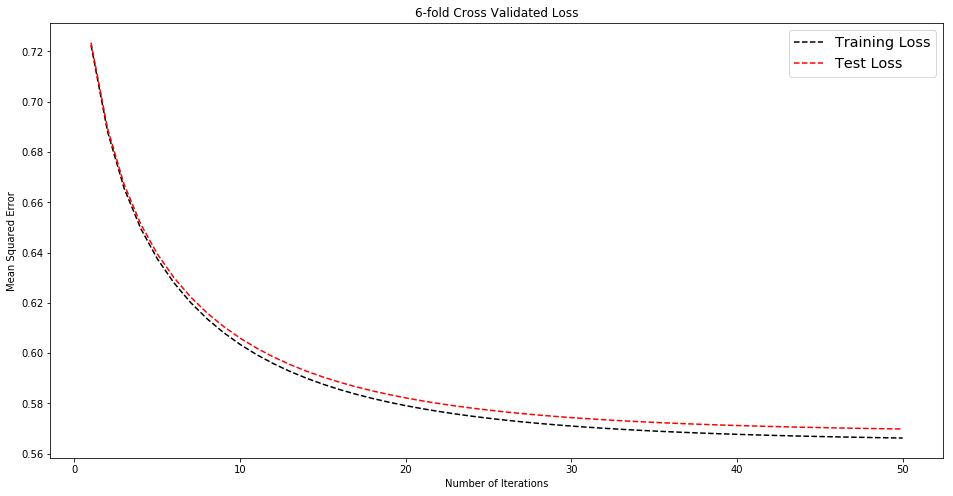

In [300]:
# plot
plot_error_curve(train_losses, test_losses, title = '6-fold Cross Validated Loss' )

# Regularization.

Our goal, as always, is to build a linear model that will extend well to unseen data. Chosing the right combination of features to optimize generalizability can be extremely computationally costly given that there are $2^{p}$ potential models that can be built from $p$ features. Traditional methods like forward selection would involve iteratively testing these options to asses which combinations of features achieve a statistically significant prediction.

Ridge Regression and Lasso Regression are two popular alternatives to OLS, which enable us to train generalizable models without the trouble of forward selection and/or manual feature selection.  Both methods take advantage of the bias-variance tradeoff by _shrinking_ the model coefficients towards 0 which reduces the variance of our model with little increase in bias. In practice this 'shrinkage' is achieved by adding a penalty (a.k.a. 'regularization') term to the means squared error loss function. Following are the implementations of Gradient Descent with ridge and lasso regularization.

__`NOTE:`__ When performing regularization _do not_ include the bias in your regularization term calcultion (Recall, that throughout this assignment we've included the bias at index 0 in the vector of weights that is your model).


In [301]:
# gradient descent with regularization
def gd_update_with_regularization(rdd, weights, lr=0.1, regularization_type=None, regularization_factor=0.1):
    """
    Perform one gradient descent step/update with ridge or lasso regularization.
    Args:
        dataRDD - tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
        learningRate - (float) defaults to 0.1
        regType - (str) 'ridge' or 'lasso', defaults to None
        regParam - (float) regularization term coefficient
    Returns:
        model   - (array) updated coefficients, bias still at index 0
    """
    # augmented data
    augmented_data = rdd.map(lambda x: (np.append([1.0], x[0]), x[1]))

    grad = None
    if regularization_type == 'ridge':
        grad = augmented_data.map(lambda x: (np.dot(x[0], weights), x[1], x[0])).map(lambda x: np.dot(x[0]- x[1] + regularization_factor * np.sum(np.square(weights[1:])), x[2]))
        
    elif regularization_type == 'lasso':
        grad = augmented_data.map(lambda x: (np.dot(x[0], weights), x[1], x[0])).map(lambda x: np.dot(x[0]- x[1] + regularization_factor * np.sum(np.absolute(weights[1:])), x[2]))
    else:
        grad = augmented_data.map(lambda x: (np.dot(x[0], weights), x[1], x[0])).map(lambda x: np.dot(x[0]- x[1], x[2]))
    
    total = grad.count()
    grad_sum = grad.sum()
    new_model = weights - lr * (1.0 / total) * grad_sum

    return new_model

In [302]:
# ridge/lasso gradient descent function
def gd_with_regularization(train_rdd, test_rdd, initial_weights, num_iterations=20, lr=0.1,
                         regularization_type=None, regularization_factor=0.1):
    """
    Perform nSteps iterations of regularized gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # initialize lists to track model performance
    train_losses, test_losses, model_params = [], [], []
    
    # perform n updates & compute test and train loss after each
    model = initial_weights
    for idx in range(num_iterations):  
        # update the model
        model = gd_update_with_regularization(train_rdd, model, lr, regularization_type, regularization_factor)
        
        # keep track of test/train loss for plotting
        train_loss = ols_loss(train_rdd, model)
        test_loss = ols_loss(test_rdd, model)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        model_params.append(model)

        print("----------")
        print(f"STEP: {idx+1}")
        print(f"training loss: {train_loss}")
        print(f"test loss: {test_loss}")
        print(f"Model: {[round(w,3) for w in model]}")
    return train_losses, test_losses, model_params

In [303]:
# run 50 iterations of ridge
initial_weights = BASELINE
train_rdd, test_rdd = normalized_rdd.randomSplit([0.8,0.2], seed = 5)
start = time.time()
ridge_results = gd_with_regularization(train_rdd, test_rdd, initial_weights, num_iterations=50, 
                                     regularization_type='ridge', regularization_factor = 0.2 )
print(f"\n... trained {len(ridge_results[2])} iterations in {time.time() - start} seconds")

----------
STEP: 1
training loss: 0.8504111624228351
test loss: 0.847422643629693
Model: [5.871, -0.009, -0.017, -0.001, -0.007, -0.02, 0.001, -0.015, -0.026, 0.01, 0.006, 0.039]
----------
STEP: 2
training loss: 0.8296038807451045
test loss: 0.8275242489943462
Model: [5.87, -0.016, -0.031, -0.001, -0.008, -0.035, 0.005, -0.024, -0.044, 0.017, 0.011, 0.07]
----------
STEP: 3
training loss: 0.8157040051974072
test loss: 0.8144049822495478
Model: [5.868, -0.02, -0.044, -0.0, -0.006, -0.047, 0.011, -0.029, -0.056, 0.022, 0.017, 0.095]
----------
STEP: 4
training loss: 0.8057038018640209
test loss: 0.8051193525672329
Model: [5.867, -0.024, -0.056, 0.001, -0.001, -0.056, 0.017, -0.033, -0.065, 0.026, 0.021, 0.116]
----------
STEP: 5
training loss: 0.7980592643961362
test loss: 0.7981516242888458
Model: [5.866, -0.026, -0.066, 0.002, 0.005, -0.064, 0.023, -0.035, -0.071, 0.029, 0.025, 0.135]
----------
STEP: 6
training loss: 0.7919520495695836
test loss: 0.7926945874888578
Model: [5.864, -0.

----------
STEP: 47
training loss: 0.7524493996841591
test loss: 0.76521825792307
Model: [5.819, -0.017, -0.171, -0.0, 0.185, -0.047, 0.09, -0.034, -0.109, 0.052, 0.06, 0.359]
----------
STEP: 48
training loss: 0.7523987121299683
test loss: 0.7652719688282791
Model: [5.819, -0.017, -0.171, -0.001, 0.186, -0.046, 0.09, -0.033, -0.11, 0.052, 0.06, 0.36]
----------
STEP: 49
training loss: 0.7523529477687495
test loss: 0.7653265565925288
Model: [5.818, -0.017, -0.172, -0.001, 0.188, -0.046, 0.09, -0.033, -0.111, 0.053, 0.06, 0.362]
----------
STEP: 50
training loss: 0.7523116346026943
test loss: 0.7653817246818745
Model: [5.818, -0.016, -0.172, -0.001, 0.189, -0.045, 0.09, -0.033, -0.111, 0.053, 0.06, 0.363]

... trained 50 iterations in 10.763897180557251 seconds


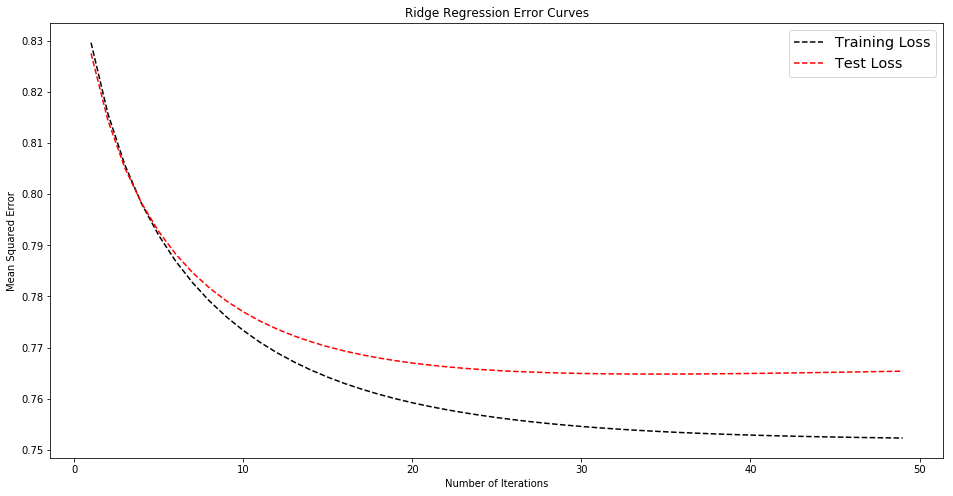

In [304]:
# save and display ridge results
trainLoss, testLoss, models = ridge_results
np.savetxt(PWD + '/data/ridge_models.csv', np.array(models), delimiter=',')
np.savetxt(PWD + '/data/ridge_loss.csv', np.array([trainLoss, testLoss]), delimiter=',')
plotErrorCurves(trainLoss, testLoss, title = 'Ridge Regression Error Curves' )

In [305]:
# run 50 iterations of lasso 
initial_weights = BASELINE
train_rdd, test_rdd = normalized_rdd.randomSplit([0.8,0.2], seed = 5)
start = time.time()
lasso_results = gd_with_regularization(train_rdd, test_rdd, initial_weights, num_iterations=50, 
                                     regularization_type='lasso', regularization_factor = 0.5 )
print(f"\n... trained {len(lasso_results[2])} iterations in {time.time() - start} seconds")

----------
STEP: 1
training loss: 0.8504111624228351
test loss: 0.847422643629693
Model: [5.871, -0.009, -0.017, -0.001, -0.007, -0.02, 0.001, -0.015, -0.026, 0.01, 0.006, 0.039]
----------
STEP: 2
training loss: 0.8295230768378531
test loss: 0.8280522257004778
Model: [5.862, -0.016, -0.031, -0.001, -0.009, -0.035, 0.005, -0.024, -0.044, 0.017, 0.011, 0.07]
----------
STEP: 3
training loss: 0.8156907309801605
test loss: 0.8160031070433724
Model: [5.849, -0.021, -0.044, -0.0, -0.006, -0.047, 0.01, -0.03, -0.056, 0.022, 0.016, 0.095]
----------
STEP: 4
training loss: 0.8060875643252214
test loss: 0.8083642691393168
Model: [5.832, -0.024, -0.056, 0.001, -0.001, -0.056, 0.017, -0.033, -0.065, 0.026, 0.021, 0.116]
----------
STEP: 5
training loss: 0.7992842694220399
test loss: 0.8036407458432209
Model: [5.814, -0.027, -0.066, 0.002, 0.005, -0.063, 0.023, -0.035, -0.071, 0.029, 0.025, 0.135]
----------
STEP: 6
training loss: 0.7945562769066115
test loss: 0.8010899174927333
Model: [5.795, -0.

----------
STEP: 47
training loss: 0.9204161245661535
test loss: 0.9677433855445179
Model: [5.327, -0.018, -0.171, 0.0, 0.184, -0.047, 0.09, -0.033, -0.109, 0.052, 0.059, 0.359]
----------
STEP: 48
training loss: 0.9220842534270627
test loss: 0.9696075716776057
Model: [5.324, -0.017, -0.172, -0.0, 0.186, -0.046, 0.09, -0.033, -0.11, 0.052, 0.059, 0.36]
----------
STEP: 49
training loss: 0.9236726496394944
test loss: 0.9713813515337898
Model: [5.321, -0.017, -0.172, -0.0, 0.188, -0.045, 0.09, -0.033, -0.111, 0.053, 0.059, 0.362]
----------
STEP: 50
training loss: 0.9252012570386738
test loss: 0.9730864917019107
Model: [5.318, -0.017, -0.172, -0.001, 0.189, -0.044, 0.09, -0.033, -0.111, 0.053, 0.059, 0.363]

... trained 50 iterations in 10.331828117370605 seconds


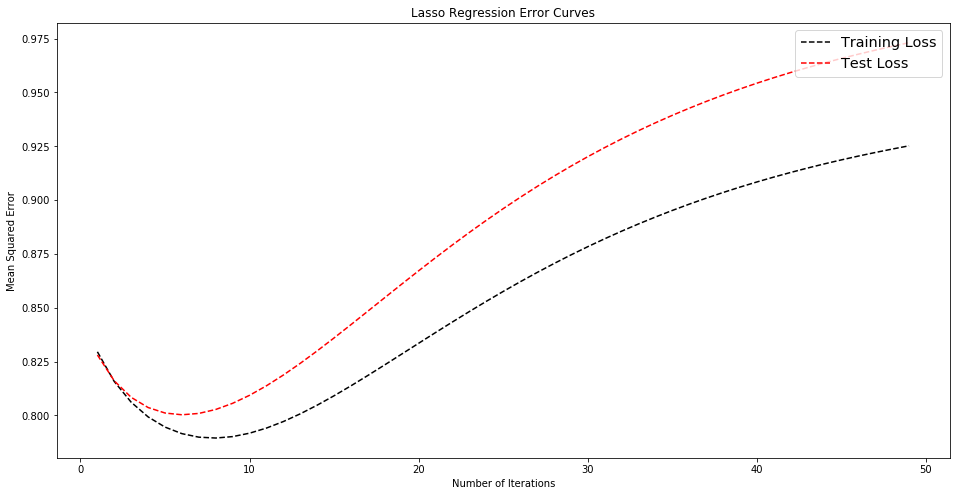

In [306]:
# save and display lasso results
trainLoss, testLoss, models = lasso_results
np.savetxt(PWD + '/data/lasso_models.csv', np.array(models), delimiter=',')
np.savetxt(PWD + '/data/lasso_loss.csv', np.array([trainLoss, testLoss]), delimiter=',')
plotErrorCurves(trainLoss, testLoss, title = 'Lasso Regression Error Curves' )

# Results

We'll use a few different plots to help us compare the OLS, Ridge and Lasso models that we have trained. We'll load the training history from file and retrieve the best (i.e. last) model from each method.



In [161]:
# load the models from file 
ols_models = np.loadtxt(PWD + '/data/OLSmodels.csv', dtype=float, delimiter=',')
ridge_models = np.loadtxt(PWD + '/data/ridge_models.csv', dtype=float, delimiter=',')
lasso_models = np.loadtxt(PWD + '/data/lasso_models.csv', dtype=float, delimiter=',')
best_ols = ols_models[-1,:]
best_ridge = ridge_models[-1,:]
best_lasso = lasso_models[-1,:]

In [162]:
# compute MSE on the held out data for all three 'best' models
olsMSE, ridgeMSE, lassoMSE = None, None, None
############### YOUR CODE HERE #################
heldOutRDDCached = heldOutRDD.map(parse).cache()

olsMSE = OLSLoss(heldOutRDDCached, best_ols)
ridgeMSE = OLSLoss(heldOutRDDCached, best_ridge)
lassoMSE = OLSLoss(heldOutRDDCached, best_lasso)


############### YOUR CODE HERE #################

print(f"OLS Mean Squared Error: {olsMSE}")
print(f"Ridge Mean Squared Error: {ridgeMSE}")
print(f"Lasso Mean Squared Error: {lassoMSE}")

NameError: name 'heldOutRDD' is not defined

In [385]:

def get_residuals(dataRDD, model):
    """
    Return a collected list of tuples (residual, quality_score)
    """
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    residuals = augmentedData.map(lambda x: (x[1] - model.dot(x[0]), x[1]))
    return residuals.collect()

In [386]:
# compute residuals for all three models
validationRDD = heldOutRDDCached
ols_resid = np.array(get_residuals(validationRDD, best_ols))
ridge_resid = np.array(get_residuals(validationRDD, best_ridge))
lasso_resid = np.array(get_residuals(validationRDD, best_lasso))

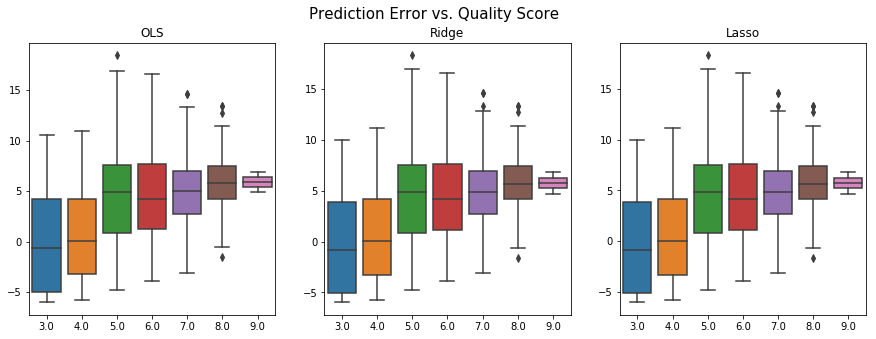

In [387]:
# boxplots of residuals for all three models
fig, axes = plt.subplots(1, 3, figsize=(15,5))
stuff_to_plot = zip(axes, ["OLS", "Ridge", "Lasso"], [ols_resid, ridge_resid, lasso_resid])
for ax, title, data in stuff_to_plot:
    ax.set_title(title)
    y = data[:, 0]
    x = data[:, 1]
    sns.boxplot(x, y, ax=ax)
fig.suptitle("Prediction Error vs. Quality Score", fontsize=15, y=0.98)
plt.show()

In [308]:
# plotting function
def plotCoeffs(models, featureNames, title):
    """
    Helper Function to show how coefficients change as we train.
    """
    fig, ax = plt.subplots(figsize = (15,8))
    X = list(range(len(models)))
    for data, name in zip(models.T, featureNames):
        if name == "Bias":
            continue
        ax.plot(X, data, label=name)
    ax.plot(X,[0]*len(X), 'k--')
    plt.title(title)
    plt.legend()
    plt.show

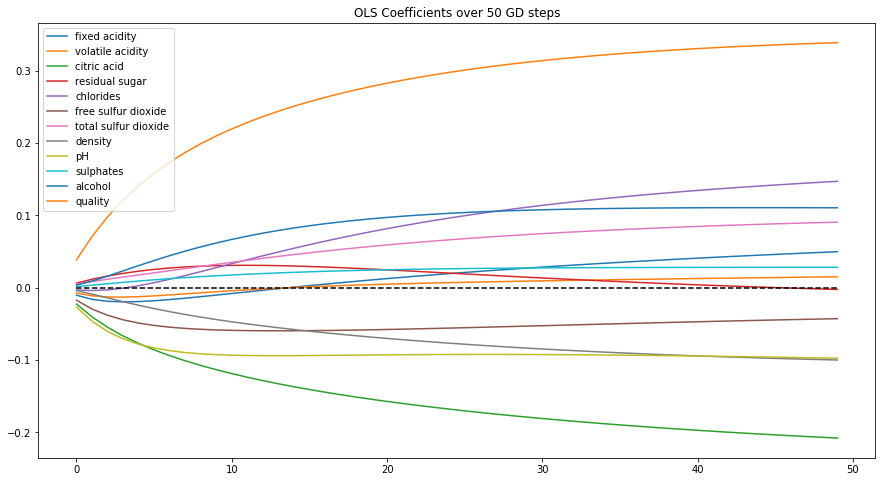

In [309]:
# take a look 
plotCoeffs(ols_models, ['Bias'] + FIELDS, "OLS Coefficients over 50 GD steps")

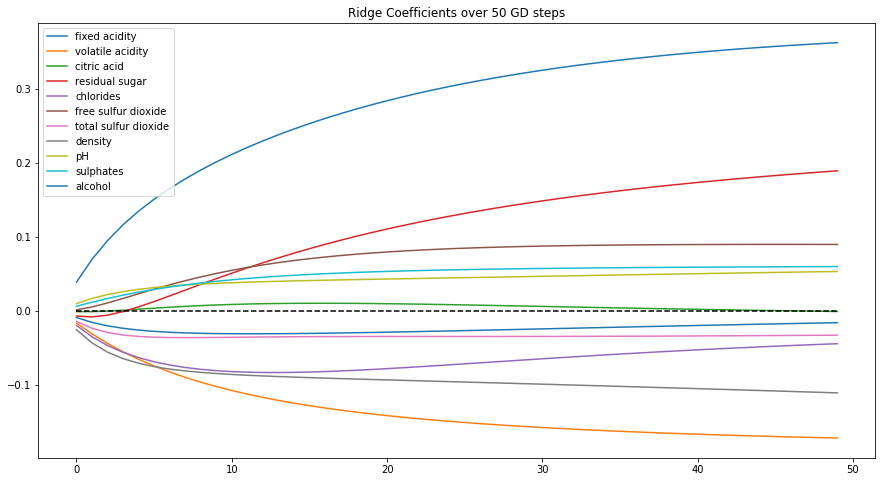

In [310]:
# take a look
plotCoeffs(ridge_models, ['Bias'] + FIELDS, "Ridge Coefficients over 50 GD steps")

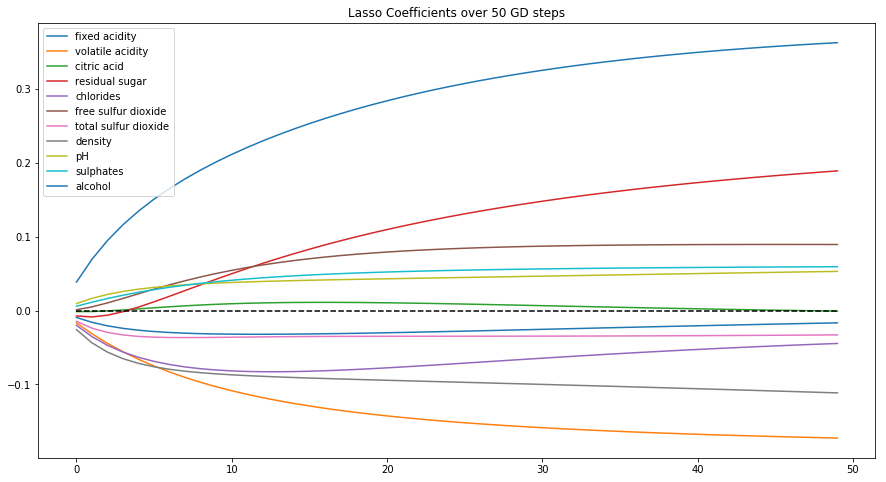

In [311]:
# take a look
plotCoeffs(lasso_models, ['Bias'] + FIELDS, "Lasso Coefficients over 50 GD steps")

### Congratulations!